This notebook is basically a copy of notebook 08, but with using the newer "correct" model

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import json
from math import prod
from huggingface_hub import hf_hub_download
import tqdm
transform_t_to_pil = T.ToPILImage()
transform_to_t = transforms.Compose([transforms.ToTensor()])
import utils
from utils import get_all_bounding_boxes, segment, calculate_initial_theta, stack_alpha_aware, AestheticPredictor
#from lion_pytorch import Lion
from datetime import datetime
import random

In [2]:
im = Image.open('combined/5373.jpg')
im = im.convert('RGBA')
im = im.resize((1440, 2560), Image.Resampling.LANCZOS)


with open("combined/5373.json", "r") as f:
    image_json = json.load(f)

reduced_segments = [s for s in segment(im,image_json) if (prod(s[0].size) < 0.80*prod(im.size)) and (prod(s[0].size)>1)]
even_more_reduced_segments = [reduced_segments[i] for i in [2,4,5,6,7,8,10,11,12]]

In [3]:
class MultiSegmentUIOptimizerWithBackgroundParam(torch.nn.Module):
    def __init__(self,segments_and_positions: list, original_image_size: tuple):
        super().__init__()
        self.original_image_size = original_image_size
        self.segments_and_positions = segments_and_positions
        self.canvas_size = (1,3,original_image_size[1],original_image_size[0])
        print(f"Canvas size is {self.canvas_size}")

        initial_vector = []
        for segment,position in segments_and_positions:
            # initial_theta = calculate_initial_theta(segment,original_image_size,position)
            initial_theta = get_random_initial_position(segment,original_image_size,position)
            initial_vector.append([initial_theta[0][2],initial_theta[1][2]])

        self.coordinates = torch.nn.Parameter(torch.tensor(initial_vector))
        print(self.coordinates)
        # self.background_color = torch.nn.Parameter(torch.tensor(np.array([1.0,1.0,1.0]),dtype=torch.float))
        self.background_color = torch.tensor(np.array([1.0,1.0,1.0]),dtype=torch.float)
        

    def forward(self):
        segments_on_canvas = []

        # Create background image from parameter
        bg_col = torch.clamp(self.background_color, min=0, max=1)
        #print(f"Clamped bg to {bg_col}")
        red = torch.tile(bg_col[0],self.original_image_size[::-1])
        green = torch.tile(bg_col[1],self.original_image_size[::-1])
        blue = torch.tile(bg_col[2],self.original_image_size[::-1])
        alpha = torch.tile(torch.tensor(0.0),self.original_image_size[::-1])
        background = torch.stack([red,green,blue,alpha]).unsqueeze(0)
        #print(background.detach().sum())
        #background = torch.tile(self.background_color,self.original_image_size)
        
        
        for n in range(len(self.segments_and_positions)):
            # We need to calculate the proper ratios, to artificially warp the segment on to a bigger canvas without distorting it (see notebook 01)
            x_ratio = self.original_image_size[0] / self.segments_and_positions[n][0].size[0]
            y_ratio = self.original_image_size[1] / self.segments_and_positions[n][0].size[1]
            
            # Affine matrix
            theta = [
                [x_ratio, 0.0    , 0.0],
                [0.0    , y_ratio, 0.0]
            ]
            theta_tensor = torch.as_tensor(theta)[None]

            theta_tensor[0][0][2]+=self.coordinates[n][0]
            theta_tensor[0][1][2]+=self.coordinates[n][1]
            
            # Generate flow field
            grid = F.affine_grid(theta_tensor, self.canvas_size).type(torch.FloatTensor)
            x = F.grid_sample(transform_to_t(self.segments_and_positions[n][0]).unsqueeze(0), grid)
            segments_on_canvas.append(x)

        segments_on_canvas.append(background)

        return segments_on_canvas

In [20]:
def get_random_initial_position(segment, canvas_size, original_position, seed=1):
    # random.seed(seed)

    
    # Theta consists of 6 values, 4 of which we have to calculate.
    x_ratio = canvas_size[0] / segment.size[0]
    y_ratio = canvas_size[1] / segment.size[1]
    
    mapped_x_position = random.uniform(-(x_ratio-1), (x_ratio-1))
    mapped_y_position = random.uniform(-(y_ratio-1), (y_ratio-1))

    print(f"Original would have been: {calculate_initial_theta(segment,canvas_size,original_position)}")
    print(f"""Now is {np.array([ 
        [x_ratio, 0.0    , mapped_x_position],
        [0.0    , y_ratio, mapped_y_position]
    ])}""")

    
    return np.array([
        [x_ratio, 0.0    , mapped_x_position],
        [0.0    , y_ratio, mapped_y_position]
    ])

In [23]:
msUIo_wbg = MultiSegmentUIOptimizerWithBackgroundParam(even_more_reduced_segments, im.size)

Canvas size is (1, 3, 2560, 1440)
Original would have been: [[ 8.571429  0.       -5.804762]
 [ 0.       15.238095 13.30372 ]]
Now is [[ 8.571429  0.       -3.10535 ]
 [ 0.       15.238095 -5.388376]]
Original would have been: [[ 2.93279   0.        1.632134]
 [ 0.       27.526882 21.304402]]
Now is [[ 2.93279   0.        0.245321]
 [ 0.       27.526882  2.423257]]
Original would have been: [[ 1.698113  0.        0.589518]
 [ 0.       18.028169 12.066054]]
Now is [[  1.698113   0.         0.113313]
 [  0.        18.028169 -16.44071 ]]
Original would have been: [[ 1.621622  0.        0.524925]
 [ 0.       10.578512  5.305598]]
Now is [[ 1.621622  0.        0.375932]
 [ 0.       10.578512  9.403254]]
Original would have been: [[ 2.67658   0.        1.415779]
 [ 0.       33.684211 11.209663]]
Now is [[ 2.676580e+00  0.000000e+00 -5.282062e-03]
 [ 0.000000e+00  3.368421e+01 -1.203653e+01]]
Original would have been: [[ 3.243243  0.        1.894294]
 [ 0.       33.684211  9.269038]]
Now is [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


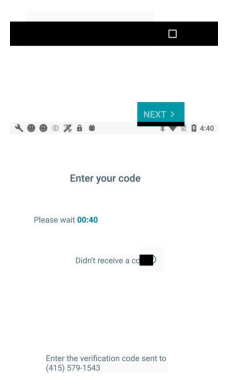

In [24]:
canvasses = msUIo_wbg()


generated_image = stack_alpha_aware(canvasses)
# Remove Alpha channel
generated_image = generated_image[:3]

plt.imshow(generated_image.detach().permute(1, 2, 0))

plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


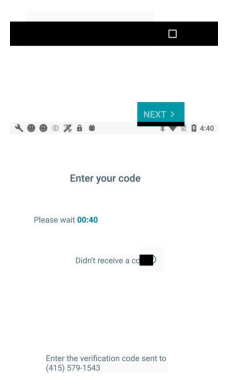

In [26]:
plt.imshow(generated_image.detach().permute(1, 2, 0))
plt.axis('off')
plt.savefig('01_start_image.png',bbox_inches='tight')


In [27]:
appsthetics_predictor = torch.load("Dataset_estetica/Regressao/model34-1cycle-2ndStage-best")

In [28]:
appsthetics_predictor["model"].eval()
1

1

In [29]:
# optimizer = Lion(msUIo_wbg.parameters(), lr=0.005)
optimizer = torch.optim.AdamW(msUIo_wbg.parameters(), lr=0.005)

In [30]:
resnet_transform = transforms.Compose([
    transforms.Resize((448, 448)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [31]:
scores = []
images_for_gif = []

for x in tqdm.tqdm(range(100)):
    optimizer.zero_grad()
    canvasses = msUIo_wbg()
    
    generated_image = stack_alpha_aware(canvasses)
    # Remove Alpha channel
    generated_image = generated_image[:3]
    
    #plt.hist(resnet_transform(generated_image)[0].cpu().detach())
    #plt.show()
    #plt.imshow(resnet_transform(generated_image).permute(1,2,0).cpu().detach())
    #plt.show()
    #break
    # print(generated_image)

    score = appsthetics_predictor["model"](resnet_transform(generated_image.unsqueeze(0)))
    print(score.detach().item())

    loss = -score
    loss.backward()
    optimizer.step()

    scores.append(score.detach().item())

    # Save image as png to create gif
    pil_image = transform_t_to_pil(generated_image.detach())
    pil_image = pil_image.resize((int(pil_image.size[0]/4),int(pil_image.size[1]/4)), Image.Resampling.LANCZOS)
    pil_image.save(f"{x}.png")
    images_for_gif.append(f"{x}.png")
    #pbar.set_description(f"Score: {score}")
    #pbar.refresh()

print(f"Final Score: {score[-1]}")

  0%|          | 0/100 [00:00<?, ?it/s]

0.39956164360046387


  1%|          | 1/100 [00:03<05:33,  3.37s/it]

0.42158669233322144


  2%|▏         | 2/100 [00:06<05:08,  3.15s/it]

0.4309200942516327


  3%|▎         | 3/100 [00:09<05:17,  3.28s/it]

0.4420616626739502


  4%|▍         | 4/100 [00:13<05:13,  3.27s/it]

0.4372820258140564


  5%|▌         | 5/100 [00:16<05:14,  3.31s/it]

0.4488648474216461


  6%|▌         | 6/100 [00:19<05:10,  3.30s/it]

0.43704891204833984


  7%|▋         | 7/100 [00:23<05:07,  3.31s/it]

0.4121215343475342


  8%|▊         | 8/100 [00:26<05:05,  3.32s/it]

0.41852885484695435


  9%|▉         | 9/100 [00:29<04:58,  3.28s/it]

0.42966172099113464


 10%|█         | 10/100 [00:32<04:52,  3.25s/it]

0.4319252073764801


 11%|█         | 11/100 [00:35<04:48,  3.24s/it]

0.4342804551124573


 12%|█▏        | 12/100 [00:39<04:45,  3.25s/it]

0.44765305519104004


 13%|█▎        | 13/100 [00:42<04:50,  3.33s/it]

0.454284131526947


 14%|█▍        | 14/100 [00:46<04:43,  3.30s/it]

0.44659900665283203


 15%|█▌        | 15/100 [00:49<04:40,  3.30s/it]

0.4577893614768982


 16%|█▌        | 16/100 [00:52<04:32,  3.24s/it]

0.47853973507881165


 17%|█▋        | 17/100 [00:55<04:28,  3.23s/it]

0.46031978726387024


 18%|█▊        | 18/100 [00:58<04:25,  3.24s/it]

0.45890191197395325


 19%|█▉        | 19/100 [01:02<04:23,  3.25s/it]

0.45518168807029724


 20%|██        | 20/100 [01:05<04:21,  3.26s/it]

0.47015097737312317


 21%|██        | 21/100 [01:08<04:20,  3.30s/it]

0.46696069836616516


 22%|██▏       | 22/100 [01:12<04:14,  3.27s/it]

0.47837361693382263


 23%|██▎       | 23/100 [01:15<04:06,  3.20s/it]

0.47316259145736694


 24%|██▍       | 24/100 [01:18<04:04,  3.22s/it]

0.46291837096214294


 25%|██▌       | 25/100 [01:21<03:57,  3.17s/it]

0.47306376695632935


 26%|██▌       | 26/100 [01:24<03:58,  3.22s/it]

0.4901599586009979


 27%|██▋       | 27/100 [01:27<03:54,  3.21s/it]

0.4955519735813141


 28%|██▊       | 28/100 [01:31<03:49,  3.19s/it]

0.4861986041069031


 29%|██▉       | 29/100 [01:34<03:49,  3.23s/it]

0.48814114928245544


 30%|███       | 30/100 [01:37<03:40,  3.15s/it]

0.4839562773704529


 31%|███       | 31/100 [01:41<03:51,  3.35s/it]

0.4870282709598541


 32%|███▏      | 32/100 [01:44<03:45,  3.32s/it]

0.4893013536930084


 33%|███▎      | 33/100 [01:47<03:39,  3.27s/it]

0.49521130323410034


 34%|███▍      | 34/100 [01:50<03:35,  3.27s/it]

0.5020241141319275


 35%|███▌      | 35/100 [01:54<03:31,  3.25s/it]

0.49721550941467285


 36%|███▌      | 36/100 [01:57<03:26,  3.23s/it]

0.50319504737854


 37%|███▋      | 37/100 [02:00<03:25,  3.25s/it]

0.5078235864639282


 38%|███▊      | 38/100 [02:03<03:20,  3.24s/it]

0.5077018141746521


 39%|███▉      | 39/100 [02:07<03:18,  3.26s/it]

0.503259003162384


 40%|████      | 40/100 [02:10<03:14,  3.24s/it]

0.4990482032299042


 41%|████      | 41/100 [02:13<03:08,  3.20s/it]

0.5019285082817078


 42%|████▏     | 42/100 [02:16<03:08,  3.26s/it]

0.5051965713500977


 43%|████▎     | 43/100 [02:19<03:03,  3.21s/it]

0.5079323053359985


 44%|████▍     | 44/100 [02:23<03:02,  3.26s/it]

0.5021586418151855


 45%|████▌     | 45/100 [02:26<02:56,  3.21s/it]

0.4998246431350708


 46%|████▌     | 46/100 [02:29<02:53,  3.22s/it]

0.4976196587085724


 47%|████▋     | 47/100 [02:32<02:51,  3.23s/it]

0.5015385746955872


 48%|████▊     | 48/100 [02:36<02:49,  3.26s/it]

0.5047967433929443


 49%|████▉     | 49/100 [02:39<02:44,  3.23s/it]

0.5044434666633606


 50%|█████     | 50/100 [02:42<02:43,  3.27s/it]

0.49975085258483887


 51%|█████     | 51/100 [02:46<02:41,  3.30s/it]

0.4985359311103821


 52%|█████▏    | 52/100 [02:49<02:37,  3.28s/it]

0.5031905174255371


 53%|█████▎    | 53/100 [02:52<02:36,  3.33s/it]

0.5100231766700745


 54%|█████▍    | 54/100 [02:55<02:30,  3.27s/it]

0.5093092918395996


 55%|█████▌    | 55/100 [02:59<02:29,  3.32s/it]

0.512342095375061


 56%|█████▌    | 56/100 [03:03<02:35,  3.53s/it]

0.5059349536895752


 57%|█████▋    | 57/100 [03:06<02:31,  3.53s/it]

0.5093623399734497


 58%|█████▊    | 58/100 [03:09<02:23,  3.40s/it]

0.5125514268875122


 59%|█████▉    | 59/100 [03:13<02:18,  3.37s/it]

0.5043755769729614


 60%|██████    | 60/100 [03:16<02:12,  3.32s/it]

0.5053478479385376


 61%|██████    | 61/100 [03:19<02:09,  3.32s/it]

0.5052359700202942


 62%|██████▏   | 62/100 [03:22<02:04,  3.28s/it]

0.5059982538223267


 63%|██████▎   | 63/100 [03:26<02:00,  3.25s/it]

0.5126861333847046


 64%|██████▍   | 64/100 [03:29<01:56,  3.25s/it]

0.5055782198905945


 65%|██████▌   | 65/100 [03:32<01:55,  3.29s/it]

0.5046815872192383


 66%|██████▌   | 66/100 [03:36<01:52,  3.29s/it]

0.5033172369003296


 67%|██████▋   | 67/100 [03:39<01:48,  3.27s/it]

0.5049108862876892


 68%|██████▊   | 68/100 [03:42<01:44,  3.27s/it]

0.5054289698600769


 69%|██████▉   | 69/100 [03:45<01:41,  3.29s/it]

0.5056636929512024


 70%|███████   | 70/100 [03:49<01:38,  3.29s/it]

0.5077987313270569


 71%|███████   | 71/100 [03:52<01:39,  3.42s/it]

0.5051112174987793


 72%|███████▏  | 72/100 [03:56<01:34,  3.39s/it]

0.505713701248169


 73%|███████▎  | 73/100 [03:59<01:29,  3.32s/it]

0.5084860920906067


 74%|███████▍  | 74/100 [04:02<01:25,  3.28s/it]

0.5064070820808411


 75%|███████▌  | 75/100 [04:05<01:21,  3.27s/it]

0.5065716505050659


 76%|███████▌  | 76/100 [04:08<01:17,  3.21s/it]

0.5073573589324951


 77%|███████▋  | 77/100 [04:11<01:13,  3.19s/it]

0.5042984485626221


 78%|███████▊  | 78/100 [04:15<01:10,  3.21s/it]

0.5057591199874878


 79%|███████▉  | 79/100 [04:18<01:06,  3.18s/it]

0.5095527172088623


 80%|████████  | 80/100 [04:21<01:04,  3.20s/it]

0.5008910298347473


 81%|████████  | 81/100 [04:24<01:01,  3.25s/it]

0.5015081763267517


 82%|████████▏ | 82/100 [04:28<00:58,  3.25s/it]

0.5049836039543152


 83%|████████▎ | 83/100 [04:31<00:55,  3.25s/it]

0.507277250289917


 84%|████████▍ | 84/100 [04:34<00:52,  3.27s/it]

0.5037907361984253


 85%|████████▌ | 85/100 [04:37<00:48,  3.22s/it]

0.508953332901001


 86%|████████▌ | 86/100 [04:41<00:44,  3.21s/it]

0.5101515650749207


 87%|████████▋ | 87/100 [04:44<00:41,  3.18s/it]

0.5036755800247192


 88%|████████▊ | 88/100 [04:47<00:38,  3.20s/it]

0.5035024881362915


 89%|████████▉ | 89/100 [04:50<00:34,  3.17s/it]

0.5063006281852722


 90%|█████████ | 90/100 [04:53<00:31,  3.18s/it]

0.5104520320892334


 91%|█████████ | 91/100 [04:57<00:28,  3.21s/it]

0.5085779428482056


 92%|█████████▏| 92/100 [05:00<00:25,  3.20s/it]

0.5146859884262085


 93%|█████████▎| 93/100 [05:03<00:22,  3.21s/it]

0.5151877999305725


 94%|█████████▍| 94/100 [05:06<00:19,  3.17s/it]

0.5047624111175537


 95%|█████████▌| 95/100 [05:09<00:16,  3.22s/it]

0.5143740773200989


 96%|█████████▌| 96/100 [05:13<00:12,  3.25s/it]

0.5227032899856567


 97%|█████████▋| 97/100 [05:16<00:09,  3.26s/it]

0.5138358473777771


 98%|█████████▊| 98/100 [05:19<00:06,  3.28s/it]

0.5128185749053955


 99%|█████████▉| 99/100 [05:23<00:03,  3.30s/it]

0.515946626663208


100%|██████████| 100/100 [05:26<00:00,  3.27s/it]

Final Score: tensor([0.5159], grad_fn=<SelectBackward0>)


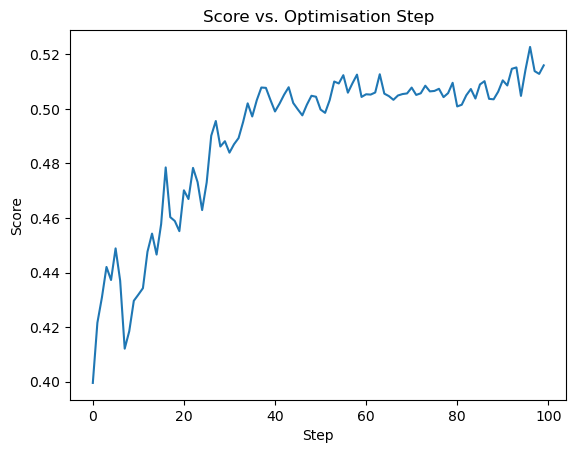

In [32]:
plt.plot(scores)
plt.title("Score vs. Optimisation Step")
plt.xlabel("Step")
plt.ylabel("Score")
plt.savefig('02_optimisation.png',bbox_inches='tight')
plt.show()

In [33]:
len(images_for_gif)

100

/tmp/ipykernel_13345/979258874.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
/tmp/ipykernel_13345/979258874.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML



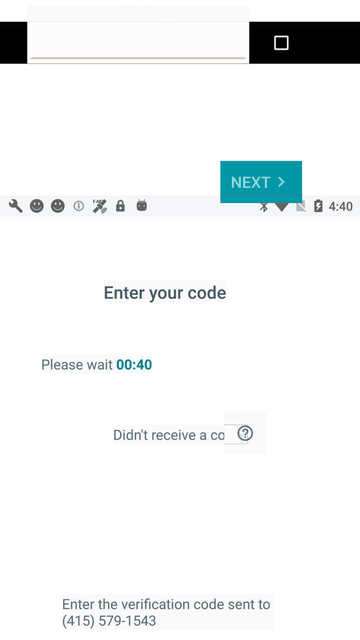

In [34]:
# Create gif from steps
import imageio

images = []
for filename in images_for_gif:
    images.append(imageio.imread(filename))

gif_filename = f"./progress_{datetime.now().isoformat(timespec='minutes')}.gif"
imageio.mimsave(gif_filename, images, loop=65535)

import base64
from IPython.core.display import display, HTML

b64 = base64.b64encode(open(gif_filename,'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


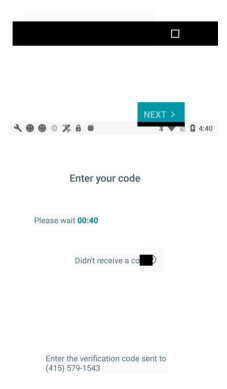

In [35]:
canvasses = msUIo_wbg()
generated_image = stack_alpha_aware(canvasses)
# Remove Alpha channel
generated_image = generated_image[:3]
plt.imshow(generated_image.detach().permute(1, 2, 0))
plt.axis('off')
plt.savefig('03_end_image.png',bbox_inches='tight')


In [15]:
new_image = (generated_image[0]*0.299+generated_image[1]*0.587+generated_image[2]*0.114)

In [16]:
new_image.shape

torch.Size([2560, 1440])

In [17]:
rgb_grayscale_im = torch.stack([new_image,new_image,new_image])

In [18]:
rgb_grayscale_im.shape

torch.Size([3, 2560, 1440])

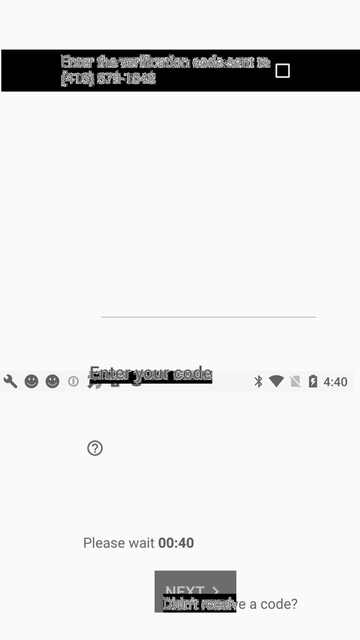

In [19]:
grayscale_pil = transform_t_to_pil(rgb_grayscale_im)
im.resize((1440, 2560), Image.Resampling.LANCZOS)
display(grayscale_pil.resize((int(grayscale_pil.size[0]/4),int(grayscale_pil.size[1]/4)),Image.Resampling.LANCZOS))

Lets apply this to our optimiser:

In [16]:
scores = []
images_for_gif = []
msUIo_wbg_gr = MultiSegmentUIOptimizerWithBackgroundParam(even_more_reduced_segments, im.size)
optimizer = torch.optim.AdamW(msUIo_wbg_gr.parameters(), lr=0.05)
for x in tqdm.tqdm(range(200)):
    optimizer.zero_grad()
    canvasses = msUIo_wbg_gr()
    
    generated_image = stack_alpha_aware(canvasses)
    # Remove Alpha channel
    generated_image = generated_image[:3]

    # Convert to grayscale
    new_image = (generated_image[0]*0.299+generated_image[1]*0.587+generated_image[2]*0.114)
    rgb_grayscale_im = torch.stack([new_image,new_image,new_image])

    #score = appsthetics_predictor(generated_image.unsqueeze(0))
    #score = appsthetics_predictor(rgb_grayscale_im.unsqueeze(0))
    score = appsthetics_predictor["model"](resnet_transform(rgb_grayscale_im.unsqueeze(0)))
    print(score)

    loss = -score
    loss.backward()
    optimizer.step()

    scores.append(score.item())

    # Save image as png to create gif
    #pil_image = transform_t_to_pil(generated_image.detach())
    pil_image = transform_t_to_pil(rgb_grayscale_im.detach())
    pil_image = pil_image.resize((int(pil_image.size[0]/4),int(pil_image.size[1]/4)), Image.Resampling.LANCZOS)
    pil_image.save(f"{x}.png")
    images_for_gif.append(f"{x}.png")
    #pbar.set_description(f"Score: {score}")
    #pbar.refresh()

print(f"Final Score: {score[-1]}")

Canvas size is (1, 3, 2560, 1440)
Original would have been: [[ 8.571429  0.       -5.804762]
 [ 0.       15.238095 13.30372 ]]
Now is [[ 8.571429  0.        4.418567]
 [ 0.       15.238095 -2.929084]]
Original would have been: [[ 2.93279   0.        1.632134]
 [ 0.       27.526882 21.304402]]
Now is [[ 2.93279   0.       -0.066799]
 [ 0.       27.526882 -8.972067]]
Original would have been: [[ 1.698113  0.        0.589518]
 [ 0.       18.028169 12.066054]]
Now is [[  1.698113   0.         0.657391]
 [  0.        18.028169 -14.086207]]
Original would have been: [[ 1.621622  0.        0.524925]
 [ 0.       10.578512  5.305598]]
Now is [[ 1.621622  0.        0.330063]
 [ 0.       10.578512 -1.827529]]
Original would have been: [[ 2.67658   0.        1.415779]
 [ 0.       33.684211 11.209663]]
Now is [[ 2.67658   0.        0.918676]
 [ 0.       33.684211 -2.526524]]
Original would have been: [[ 3.243243  0.        1.894294]
 [ 0.       33.684211  9.269038]]
Now is [[  3.243243   0.        

  0%|          | 0/200 [00:00<?, ?it/s]

tensor([[0.3328]], grad_fn=<AddmmBackward0>)


  0%|          | 1/200 [00:02<09:06,  2.74s/it]

tensor([[0.3335]], grad_fn=<AddmmBackward0>)


  1%|          | 2/200 [00:05<08:58,  2.72s/it]

tensor([[0.2813]], grad_fn=<AddmmBackward0>)


  2%|▏         | 3/200 [00:08<08:55,  2.72s/it]

tensor([[0.3070]], grad_fn=<AddmmBackward0>)


  2%|▏         | 4/200 [00:10<08:47,  2.69s/it]

tensor([[0.3360]], grad_fn=<AddmmBackward0>)


  2%|▎         | 5/200 [00:13<08:58,  2.76s/it]

tensor([[0.3912]], grad_fn=<AddmmBackward0>)


  3%|▎         | 6/200 [00:16<08:56,  2.76s/it]

tensor([[0.3260]], grad_fn=<AddmmBackward0>)


  4%|▎         | 7/200 [00:19<08:56,  2.78s/it]

tensor([[0.3745]], grad_fn=<AddmmBackward0>)


  4%|▍         | 8/200 [00:22<09:11,  2.87s/it]

tensor([[0.3189]], grad_fn=<AddmmBackward0>)


  4%|▍         | 9/200 [00:25<09:09,  2.88s/it]

tensor([[0.3777]], grad_fn=<AddmmBackward0>)


  5%|▌         | 10/200 [00:27<08:57,  2.83s/it]

tensor([[0.3473]], grad_fn=<AddmmBackward0>)


  6%|▌         | 11/200 [00:31<09:09,  2.91s/it]

tensor([[0.3513]], grad_fn=<AddmmBackward0>)


  6%|▌         | 12/200 [00:33<08:53,  2.84s/it]

tensor([[0.3841]], grad_fn=<AddmmBackward0>)


  6%|▋         | 13/200 [00:36<09:06,  2.92s/it]

tensor([[0.3715]], grad_fn=<AddmmBackward0>)


  7%|▋         | 14/200 [00:39<08:52,  2.86s/it]

tensor([[0.3933]], grad_fn=<AddmmBackward0>)


  8%|▊         | 15/200 [00:42<08:52,  2.88s/it]

tensor([[0.3733]], grad_fn=<AddmmBackward0>)


  8%|▊         | 16/200 [00:45<08:50,  2.88s/it]

tensor([[0.3804]], grad_fn=<AddmmBackward0>)


  8%|▊         | 17/200 [00:48<08:46,  2.88s/it]

tensor([[0.4286]], grad_fn=<AddmmBackward0>)


  9%|▉         | 18/200 [00:51<08:51,  2.92s/it]

tensor([[0.3807]], grad_fn=<AddmmBackward0>)


 10%|▉         | 19/200 [00:54<08:54,  2.95s/it]

tensor([[0.3485]], grad_fn=<AddmmBackward0>)


 10%|█         | 20/200 [00:57<09:29,  3.16s/it]

tensor([[0.3529]], grad_fn=<AddmmBackward0>)


 10%|█         | 21/200 [01:00<08:59,  3.01s/it]

tensor([[0.3955]], grad_fn=<AddmmBackward0>)


 11%|█         | 22/200 [01:03<09:01,  3.04s/it]

tensor([[0.4237]], grad_fn=<AddmmBackward0>)


 12%|█▏        | 23/200 [01:06<08:55,  3.02s/it]

tensor([[0.4553]], grad_fn=<AddmmBackward0>)


 12%|█▏        | 24/200 [01:09<08:47,  3.00s/it]

tensor([[0.4684]], grad_fn=<AddmmBackward0>)


 12%|█▎        | 25/200 [01:12<08:43,  2.99s/it]

tensor([[0.4914]], grad_fn=<AddmmBackward0>)


 13%|█▎        | 26/200 [01:15<08:31,  2.94s/it]

tensor([[0.4882]], grad_fn=<AddmmBackward0>)


 14%|█▎        | 27/200 [01:18<08:13,  2.85s/it]

tensor([[0.5014]], grad_fn=<AddmmBackward0>)


 14%|█▍        | 28/200 [01:20<08:08,  2.84s/it]

tensor([[0.4909]], grad_fn=<AddmmBackward0>)


 14%|█▍        | 29/200 [01:23<08:12,  2.88s/it]

tensor([[0.4977]], grad_fn=<AddmmBackward0>)


 15%|█▌        | 30/200 [01:26<08:12,  2.89s/it]

tensor([[0.4572]], grad_fn=<AddmmBackward0>)


 16%|█▌        | 31/200 [01:29<08:05,  2.87s/it]

tensor([[0.5060]], grad_fn=<AddmmBackward0>)


 16%|█▌        | 32/200 [01:32<08:08,  2.91s/it]

tensor([[0.4788]], grad_fn=<AddmmBackward0>)


 16%|█▋        | 33/200 [01:35<07:58,  2.87s/it]

tensor([[0.4858]], grad_fn=<AddmmBackward0>)


 17%|█▋        | 34/200 [01:38<08:08,  2.94s/it]

tensor([[0.4459]], grad_fn=<AddmmBackward0>)


 18%|█▊        | 35/200 [01:41<07:56,  2.89s/it]

tensor([[0.4093]], grad_fn=<AddmmBackward0>)


 18%|█▊        | 36/200 [01:44<08:01,  2.94s/it]

tensor([[0.4224]], grad_fn=<AddmmBackward0>)


 18%|█▊        | 37/200 [01:46<07:46,  2.86s/it]

tensor([[0.4593]], grad_fn=<AddmmBackward0>)


 19%|█▉        | 38/200 [01:50<07:58,  2.95s/it]

tensor([[0.4522]], grad_fn=<AddmmBackward0>)


 20%|█▉        | 39/200 [01:52<07:30,  2.80s/it]

tensor([[0.5105]], grad_fn=<AddmmBackward0>)


 20%|██        | 40/200 [01:55<07:28,  2.80s/it]

tensor([[0.5146]], grad_fn=<AddmmBackward0>)


 20%|██        | 41/200 [01:58<07:16,  2.75s/it]

tensor([[0.5019]], grad_fn=<AddmmBackward0>)


 21%|██        | 42/200 [02:01<07:48,  2.97s/it]

tensor([[0.4485]], grad_fn=<AddmmBackward0>)


 22%|██▏       | 43/200 [02:04<08:05,  3.09s/it]

tensor([[0.3816]], grad_fn=<AddmmBackward0>)


 22%|██▏       | 44/200 [02:07<08:02,  3.09s/it]

tensor([[0.4165]], grad_fn=<AddmmBackward0>)


 22%|██▎       | 45/200 [02:10<07:43,  2.99s/it]

tensor([[0.4825]], grad_fn=<AddmmBackward0>)


 23%|██▎       | 46/200 [02:13<07:38,  2.98s/it]

tensor([[0.5730]], grad_fn=<AddmmBackward0>)


 24%|██▎       | 47/200 [02:16<07:18,  2.86s/it]

tensor([[0.4836]], grad_fn=<AddmmBackward0>)


 24%|██▍       | 48/200 [02:19<07:18,  2.89s/it]

tensor([[0.4771]], grad_fn=<AddmmBackward0>)


 24%|██▍       | 49/200 [02:22<07:16,  2.89s/it]

tensor([[0.5107]], grad_fn=<AddmmBackward0>)


 25%|██▌       | 50/200 [02:25<07:18,  2.92s/it]

tensor([[0.4078]], grad_fn=<AddmmBackward0>)


 26%|██▌       | 51/200 [02:27<07:11,  2.90s/it]

tensor([[0.4192]], grad_fn=<AddmmBackward0>)


 26%|██▌       | 52/200 [02:31<07:19,  2.97s/it]

tensor([[0.5151]], grad_fn=<AddmmBackward0>)


 26%|██▋       | 53/200 [02:34<07:17,  2.98s/it]

tensor([[0.5073]], grad_fn=<AddmmBackward0>)


 27%|██▋       | 54/200 [02:37<07:17,  3.00s/it]

tensor([[0.4986]], grad_fn=<AddmmBackward0>)


 28%|██▊       | 55/200 [02:39<06:43,  2.78s/it]

tensor([[0.5037]], grad_fn=<AddmmBackward0>)


 28%|██▊       | 56/200 [02:42<06:53,  2.87s/it]

tensor([[0.4890]], grad_fn=<AddmmBackward0>)


 28%|██▊       | 57/200 [02:45<06:51,  2.88s/it]

tensor([[0.4832]], grad_fn=<AddmmBackward0>)


 29%|██▉       | 58/200 [02:48<06:57,  2.94s/it]

tensor([[0.4811]], grad_fn=<AddmmBackward0>)


 30%|██▉       | 59/200 [02:51<06:45,  2.88s/it]

tensor([[0.5047]], grad_fn=<AddmmBackward0>)


 30%|███       | 60/200 [02:54<06:41,  2.87s/it]

tensor([[0.5097]], grad_fn=<AddmmBackward0>)


 30%|███       | 61/200 [02:56<06:28,  2.79s/it]

tensor([[0.5230]], grad_fn=<AddmmBackward0>)


 31%|███       | 62/200 [02:59<06:40,  2.90s/it]

tensor([[0.5377]], grad_fn=<AddmmBackward0>)


 32%|███▏      | 63/200 [03:02<06:31,  2.86s/it]

tensor([[0.5327]], grad_fn=<AddmmBackward0>)


 32%|███▏      | 64/200 [03:05<06:29,  2.86s/it]

tensor([[0.4943]], grad_fn=<AddmmBackward0>)


 32%|███▎      | 65/200 [03:08<06:27,  2.87s/it]

tensor([[0.5138]], grad_fn=<AddmmBackward0>)


 33%|███▎      | 66/200 [03:11<06:34,  2.94s/it]

tensor([[0.5273]], grad_fn=<AddmmBackward0>)


 34%|███▎      | 67/200 [03:14<06:27,  2.91s/it]

tensor([[0.5273]], grad_fn=<AddmmBackward0>)


 34%|███▍      | 68/200 [03:17<06:18,  2.87s/it]

tensor([[0.5728]], grad_fn=<AddmmBackward0>)


 34%|███▍      | 69/200 [03:19<06:12,  2.84s/it]

tensor([[0.5583]], grad_fn=<AddmmBackward0>)


 35%|███▌      | 70/200 [03:22<06:17,  2.91s/it]

tensor([[0.5301]], grad_fn=<AddmmBackward0>)


 36%|███▌      | 71/200 [03:25<06:15,  2.91s/it]

tensor([[0.5834]], grad_fn=<AddmmBackward0>)


 36%|███▌      | 72/200 [03:28<06:04,  2.84s/it]

tensor([[0.5503]], grad_fn=<AddmmBackward0>)


 36%|███▋      | 73/200 [03:31<06:19,  2.99s/it]

tensor([[0.5421]], grad_fn=<AddmmBackward0>)


 37%|███▋      | 74/200 [03:34<06:11,  2.95s/it]

tensor([[0.5487]], grad_fn=<AddmmBackward0>)


 38%|███▊      | 75/200 [03:37<06:00,  2.88s/it]

tensor([[0.5694]], grad_fn=<AddmmBackward0>)


 38%|███▊      | 76/200 [03:40<05:53,  2.85s/it]

tensor([[0.5253]], grad_fn=<AddmmBackward0>)


 38%|███▊      | 77/200 [03:42<05:46,  2.82s/it]

tensor([[0.5565]], grad_fn=<AddmmBackward0>)


 39%|███▉      | 78/200 [03:45<05:42,  2.81s/it]

tensor([[0.5313]], grad_fn=<AddmmBackward0>)


 40%|███▉      | 79/200 [03:48<05:41,  2.82s/it]

tensor([[0.5461]], grad_fn=<AddmmBackward0>)


 40%|████      | 80/200 [03:51<05:43,  2.86s/it]

tensor([[0.5554]], grad_fn=<AddmmBackward0>)


 40%|████      | 81/200 [03:54<05:47,  2.92s/it]

tensor([[0.5621]], grad_fn=<AddmmBackward0>)


 41%|████      | 82/200 [03:57<05:50,  2.97s/it]

tensor([[0.5293]], grad_fn=<AddmmBackward0>)


 42%|████▏     | 83/200 [04:00<05:49,  2.99s/it]

tensor([[0.5385]], grad_fn=<AddmmBackward0>)


 42%|████▏     | 84/200 [04:03<05:39,  2.93s/it]

tensor([[0.5616]], grad_fn=<AddmmBackward0>)


 42%|████▎     | 85/200 [04:06<05:31,  2.88s/it]

tensor([[0.5562]], grad_fn=<AddmmBackward0>)


 43%|████▎     | 86/200 [04:09<05:27,  2.88s/it]

tensor([[0.5495]], grad_fn=<AddmmBackward0>)


 44%|████▎     | 87/200 [04:11<05:18,  2.82s/it]

tensor([[0.5435]], grad_fn=<AddmmBackward0>)


 44%|████▍     | 88/200 [04:14<05:11,  2.78s/it]

tensor([[0.5288]], grad_fn=<AddmmBackward0>)


 44%|████▍     | 89/200 [04:17<05:20,  2.89s/it]

tensor([[0.5530]], grad_fn=<AddmmBackward0>)


 45%|████▌     | 90/200 [04:20<05:25,  2.96s/it]

tensor([[0.5533]], grad_fn=<AddmmBackward0>)


 46%|████▌     | 91/200 [04:23<05:24,  2.98s/it]

tensor([[0.5643]], grad_fn=<AddmmBackward0>)


 46%|████▌     | 92/200 [04:27<05:35,  3.10s/it]

tensor([[0.6052]], grad_fn=<AddmmBackward0>)


 46%|████▋     | 93/200 [04:30<05:34,  3.13s/it]

tensor([[0.6275]], grad_fn=<AddmmBackward0>)


 47%|████▋     | 94/200 [04:33<05:25,  3.07s/it]

tensor([[0.6222]], grad_fn=<AddmmBackward0>)


 48%|████▊     | 95/200 [04:36<05:32,  3.17s/it]

tensor([[0.5350]], grad_fn=<AddmmBackward0>)


 48%|████▊     | 96/200 [04:39<05:20,  3.08s/it]

tensor([[0.5503]], grad_fn=<AddmmBackward0>)


 48%|████▊     | 97/200 [04:42<05:10,  3.01s/it]

tensor([[0.5151]], grad_fn=<AddmmBackward0>)


 49%|████▉     | 98/200 [04:45<05:04,  2.98s/it]

tensor([[0.5664]], grad_fn=<AddmmBackward0>)


 50%|████▉     | 99/200 [04:48<04:53,  2.90s/it]

tensor([[0.5802]], grad_fn=<AddmmBackward0>)


 50%|█████     | 100/200 [04:50<04:40,  2.80s/it]

tensor([[0.5803]], grad_fn=<AddmmBackward0>)


 50%|█████     | 101/200 [04:53<04:48,  2.91s/it]

tensor([[0.5794]], grad_fn=<AddmmBackward0>)


 51%|█████     | 102/200 [04:56<04:43,  2.89s/it]

tensor([[0.5657]], grad_fn=<AddmmBackward0>)


 52%|█████▏    | 103/200 [04:59<04:35,  2.84s/it]

tensor([[0.5856]], grad_fn=<AddmmBackward0>)


 52%|█████▏    | 104/200 [05:02<04:28,  2.80s/it]

tensor([[0.5779]], grad_fn=<AddmmBackward0>)


 52%|█████▎    | 105/200 [05:05<04:33,  2.88s/it]

tensor([[0.5151]], grad_fn=<AddmmBackward0>)


 53%|█████▎    | 106/200 [05:07<04:29,  2.87s/it]

tensor([[0.5652]], grad_fn=<AddmmBackward0>)


 54%|█████▎    | 107/200 [05:10<04:22,  2.82s/it]

tensor([[0.5596]], grad_fn=<AddmmBackward0>)


 54%|█████▍    | 108/200 [05:13<04:24,  2.87s/it]

tensor([[0.5502]], grad_fn=<AddmmBackward0>)


 55%|█████▍    | 109/200 [05:16<04:14,  2.80s/it]

tensor([[0.5374]], grad_fn=<AddmmBackward0>)


 55%|█████▌    | 110/200 [05:19<04:21,  2.91s/it]

tensor([[0.5697]], grad_fn=<AddmmBackward0>)


 56%|█████▌    | 111/200 [05:22<04:32,  3.07s/it]

tensor([[0.5425]], grad_fn=<AddmmBackward0>)


 56%|█████▌    | 112/200 [05:25<04:25,  3.01s/it]

tensor([[0.5707]], grad_fn=<AddmmBackward0>)


 56%|█████▋    | 113/200 [05:28<04:16,  2.95s/it]

tensor([[0.5780]], grad_fn=<AddmmBackward0>)


 57%|█████▋    | 114/200 [05:31<04:13,  2.95s/it]

tensor([[0.5708]], grad_fn=<AddmmBackward0>)


 57%|█████▊    | 115/200 [05:34<04:05,  2.89s/it]

tensor([[0.5480]], grad_fn=<AddmmBackward0>)


 58%|█████▊    | 116/200 [05:37<04:03,  2.90s/it]

tensor([[0.5498]], grad_fn=<AddmmBackward0>)


 58%|█████▊    | 117/200 [05:39<03:57,  2.86s/it]

tensor([[0.5073]], grad_fn=<AddmmBackward0>)


 59%|█████▉    | 118/200 [05:42<03:52,  2.84s/it]

tensor([[0.5544]], grad_fn=<AddmmBackward0>)


 60%|█████▉    | 119/200 [05:45<03:54,  2.89s/it]

tensor([[0.5296]], grad_fn=<AddmmBackward0>)


 60%|██████    | 120/200 [05:48<03:45,  2.82s/it]

tensor([[0.5213]], grad_fn=<AddmmBackward0>)


 60%|██████    | 121/200 [05:51<03:46,  2.87s/it]

tensor([[0.4734]], grad_fn=<AddmmBackward0>)


 61%|██████    | 122/200 [05:54<03:39,  2.82s/it]

tensor([[0.5070]], grad_fn=<AddmmBackward0>)


 62%|██████▏   | 123/200 [05:57<03:43,  2.91s/it]

tensor([[0.4913]], grad_fn=<AddmmBackward0>)


 62%|██████▏   | 124/200 [06:00<03:42,  2.93s/it]

tensor([[0.5509]], grad_fn=<AddmmBackward0>)


 62%|██████▎   | 125/200 [06:03<03:40,  2.94s/it]

tensor([[0.5354]], grad_fn=<AddmmBackward0>)


 63%|██████▎   | 126/200 [06:06<03:38,  2.95s/it]

tensor([[0.5289]], grad_fn=<AddmmBackward0>)


 64%|██████▎   | 127/200 [06:09<03:37,  2.99s/it]

tensor([[0.4815]], grad_fn=<AddmmBackward0>)


 64%|██████▍   | 128/200 [06:12<03:31,  2.93s/it]

tensor([[0.5109]], grad_fn=<AddmmBackward0>)


 64%|██████▍   | 129/200 [06:14<03:22,  2.85s/it]

tensor([[0.4978]], grad_fn=<AddmmBackward0>)


 65%|██████▌   | 130/200 [06:17<03:20,  2.87s/it]

tensor([[0.5556]], grad_fn=<AddmmBackward0>)


 66%|██████▌   | 131/200 [06:20<03:16,  2.84s/it]

tensor([[0.4929]], grad_fn=<AddmmBackward0>)


 66%|██████▌   | 132/200 [06:23<03:21,  2.97s/it]

tensor([[0.4700]], grad_fn=<AddmmBackward0>)


 66%|██████▋   | 133/200 [06:26<03:14,  2.90s/it]

tensor([[0.5224]], grad_fn=<AddmmBackward0>)


 67%|██████▋   | 134/200 [06:29<03:14,  2.95s/it]

tensor([[0.5502]], grad_fn=<AddmmBackward0>)


 68%|██████▊   | 135/200 [06:32<03:06,  2.87s/it]

tensor([[0.4997]], grad_fn=<AddmmBackward0>)


 68%|██████▊   | 136/200 [06:35<03:07,  2.94s/it]

tensor([[0.4890]], grad_fn=<AddmmBackward0>)


 68%|██████▊   | 137/200 [06:37<03:00,  2.87s/it]

tensor([[0.5006]], grad_fn=<AddmmBackward0>)


 69%|██████▉   | 138/200 [06:40<02:59,  2.90s/it]

tensor([[0.5018]], grad_fn=<AddmmBackward0>)


 70%|██████▉   | 139/200 [06:44<03:00,  2.96s/it]

tensor([[0.5130]], grad_fn=<AddmmBackward0>)


 70%|███████   | 140/200 [06:46<02:56,  2.94s/it]

tensor([[0.5352]], grad_fn=<AddmmBackward0>)


 70%|███████   | 141/200 [06:50<02:57,  3.00s/it]

tensor([[0.5101]], grad_fn=<AddmmBackward0>)


 71%|███████   | 142/200 [06:52<02:49,  2.93s/it]

tensor([[0.4469]], grad_fn=<AddmmBackward0>)


 72%|███████▏  | 143/200 [06:55<02:49,  2.97s/it]

tensor([[0.4829]], grad_fn=<AddmmBackward0>)


 72%|███████▏  | 144/200 [06:58<02:45,  2.96s/it]

tensor([[0.4811]], grad_fn=<AddmmBackward0>)


 72%|███████▎  | 145/200 [07:02<02:47,  3.04s/it]

tensor([[0.4650]], grad_fn=<AddmmBackward0>)


 73%|███████▎  | 146/200 [07:04<02:41,  3.00s/it]

tensor([[0.5047]], grad_fn=<AddmmBackward0>)


 74%|███████▎  | 147/200 [07:08<02:41,  3.05s/it]

tensor([[0.5162]], grad_fn=<AddmmBackward0>)


 74%|███████▍  | 148/200 [07:11<02:36,  3.01s/it]

tensor([[0.5465]], grad_fn=<AddmmBackward0>)


 74%|███████▍  | 149/200 [07:13<02:27,  2.90s/it]

tensor([[0.5031]], grad_fn=<AddmmBackward0>)


 75%|███████▌  | 150/200 [07:16<02:27,  2.96s/it]

tensor([[0.4549]], grad_fn=<AddmmBackward0>)


 76%|███████▌  | 151/200 [07:19<02:24,  2.96s/it]

tensor([[0.4985]], grad_fn=<AddmmBackward0>)


 76%|███████▌  | 152/200 [07:22<02:22,  2.98s/it]

tensor([[0.4802]], grad_fn=<AddmmBackward0>)


 76%|███████▋  | 153/200 [07:25<02:18,  2.94s/it]

tensor([[0.4902]], grad_fn=<AddmmBackward0>)


 77%|███████▋  | 154/200 [07:28<02:12,  2.89s/it]

tensor([[0.4990]], grad_fn=<AddmmBackward0>)


 78%|███████▊  | 155/200 [07:31<02:11,  2.93s/it]

tensor([[0.5838]], grad_fn=<AddmmBackward0>)


 78%|███████▊  | 156/200 [07:34<02:06,  2.87s/it]

tensor([[0.5309]], grad_fn=<AddmmBackward0>)


 78%|███████▊  | 157/200 [07:37<02:03,  2.87s/it]

tensor([[0.4901]], grad_fn=<AddmmBackward0>)


 79%|███████▉  | 158/200 [07:39<02:01,  2.88s/it]

tensor([[0.4598]], grad_fn=<AddmmBackward0>)


 80%|███████▉  | 159/200 [07:42<01:58,  2.90s/it]

tensor([[0.4918]], grad_fn=<AddmmBackward0>)


 80%|████████  | 160/200 [07:45<01:56,  2.90s/it]

tensor([[0.5180]], grad_fn=<AddmmBackward0>)


 80%|████████  | 161/200 [07:48<01:54,  2.94s/it]

tensor([[0.4978]], grad_fn=<AddmmBackward0>)


 81%|████████  | 162/200 [07:51<01:47,  2.83s/it]

tensor([[0.4626]], grad_fn=<AddmmBackward0>)


 82%|████████▏ | 163/200 [07:54<01:47,  2.90s/it]

tensor([[0.4833]], grad_fn=<AddmmBackward0>)


 82%|████████▏ | 164/200 [07:56<01:40,  2.78s/it]

tensor([[0.4848]], grad_fn=<AddmmBackward0>)


 82%|████████▎ | 165/200 [08:00<01:41,  2.91s/it]

tensor([[0.5164]], grad_fn=<AddmmBackward0>)


 83%|████████▎ | 166/200 [08:02<01:36,  2.84s/it]

tensor([[0.5205]], grad_fn=<AddmmBackward0>)


 84%|████████▎ | 167/200 [08:05<01:33,  2.84s/it]

tensor([[0.5256]], grad_fn=<AddmmBackward0>)


 84%|████████▍ | 168/200 [08:08<01:30,  2.82s/it]

tensor([[0.5487]], grad_fn=<AddmmBackward0>)


 84%|████████▍ | 169/200 [08:11<01:29,  2.89s/it]

tensor([[0.5767]], grad_fn=<AddmmBackward0>)


 85%|████████▌ | 170/200 [08:14<01:24,  2.82s/it]

tensor([[0.5498]], grad_fn=<AddmmBackward0>)


 86%|████████▌ | 171/200 [08:16<01:22,  2.83s/it]

tensor([[0.5744]], grad_fn=<AddmmBackward0>)


 86%|████████▌ | 172/200 [08:19<01:17,  2.75s/it]

tensor([[0.5419]], grad_fn=<AddmmBackward0>)


 86%|████████▋ | 173/200 [08:22<01:16,  2.85s/it]

tensor([[0.5445]], grad_fn=<AddmmBackward0>)


 87%|████████▋ | 174/200 [08:25<01:13,  2.82s/it]

tensor([[0.5584]], grad_fn=<AddmmBackward0>)


 88%|████████▊ | 175/200 [08:28<01:12,  2.90s/it]

tensor([[0.5660]], grad_fn=<AddmmBackward0>)


 88%|████████▊ | 176/200 [08:31<01:07,  2.80s/it]

tensor([[0.5437]], grad_fn=<AddmmBackward0>)


 88%|████████▊ | 177/200 [08:34<01:07,  2.92s/it]

tensor([[0.5220]], grad_fn=<AddmmBackward0>)


 89%|████████▉ | 178/200 [08:36<01:01,  2.82s/it]

tensor([[0.5407]], grad_fn=<AddmmBackward0>)


 90%|████████▉ | 179/200 [08:39<01:01,  2.93s/it]

tensor([[0.5402]], grad_fn=<AddmmBackward0>)


 90%|█████████ | 180/200 [08:42<00:56,  2.83s/it]

tensor([[0.5577]], grad_fn=<AddmmBackward0>)


 90%|█████████ | 181/200 [08:45<00:55,  2.95s/it]

tensor([[0.5301]], grad_fn=<AddmmBackward0>)


 91%|█████████ | 182/200 [08:48<00:52,  2.93s/it]

tensor([[0.4963]], grad_fn=<AddmmBackward0>)


 92%|█████████▏| 183/200 [08:51<00:49,  2.89s/it]

tensor([[0.5094]], grad_fn=<AddmmBackward0>)


 92%|█████████▏| 184/200 [08:54<00:45,  2.85s/it]

tensor([[0.5355]], grad_fn=<AddmmBackward0>)


 92%|█████████▎| 185/200 [08:57<00:43,  2.87s/it]

tensor([[0.5189]], grad_fn=<AddmmBackward0>)


 93%|█████████▎| 186/200 [08:59<00:39,  2.83s/it]

tensor([[0.5260]], grad_fn=<AddmmBackward0>)


 94%|█████████▎| 187/200 [09:02<00:37,  2.89s/it]

tensor([[0.5417]], grad_fn=<AddmmBackward0>)


 94%|█████████▍| 188/200 [09:05<00:34,  2.85s/it]

tensor([[0.5654]], grad_fn=<AddmmBackward0>)


 94%|█████████▍| 189/200 [09:08<00:31,  2.87s/it]

tensor([[0.5638]], grad_fn=<AddmmBackward0>)


 95%|█████████▌| 190/200 [09:11<00:27,  2.75s/it]

tensor([[0.5874]], grad_fn=<AddmmBackward0>)


 96%|█████████▌| 191/200 [09:13<00:24,  2.76s/it]

tensor([[0.5994]], grad_fn=<AddmmBackward0>)


 96%|█████████▌| 192/200 [09:16<00:22,  2.78s/it]

tensor([[0.5827]], grad_fn=<AddmmBackward0>)


 96%|█████████▋| 193/200 [09:19<00:19,  2.79s/it]

tensor([[0.5920]], grad_fn=<AddmmBackward0>)


 97%|█████████▋| 194/200 [09:22<00:16,  2.82s/it]

tensor([[0.5646]], grad_fn=<AddmmBackward0>)


 98%|█████████▊| 195/200 [09:25<00:13,  2.76s/it]

tensor([[0.5717]], grad_fn=<AddmmBackward0>)


 98%|█████████▊| 196/200 [09:28<00:11,  2.88s/it]

tensor([[0.6036]], grad_fn=<AddmmBackward0>)


 98%|█████████▊| 197/200 [09:30<00:08,  2.85s/it]

tensor([[0.5786]], grad_fn=<AddmmBackward0>)


 99%|█████████▉| 198/200 [09:33<00:05,  2.89s/it]

tensor([[0.5476]], grad_fn=<AddmmBackward0>)


100%|█████████▉| 199/200 [09:36<00:02,  2.85s/it]

tensor([[0.5948]], grad_fn=<AddmmBackward0>)


100%|██████████| 200/200 [09:39<00:00,  2.90s/it]

Final Score: tensor([0.5948], grad_fn=<SelectBackward0>)


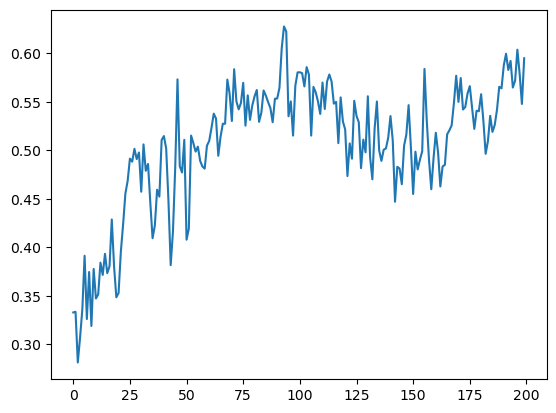

In [17]:
plt.plot(scores)
plt.show()

/tmp/ipykernel_13345/979258874.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
/tmp/ipykernel_13345/979258874.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML



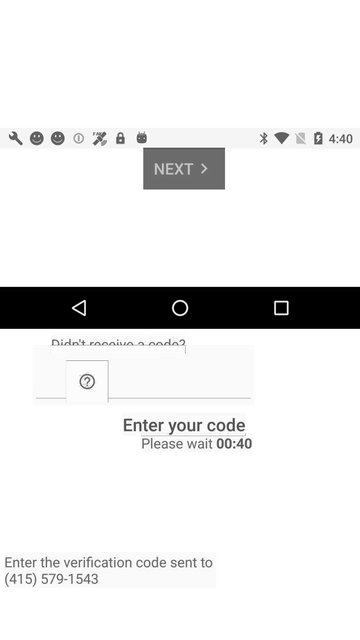

In [18]:
# Create gif from steps
import imageio

images = []
for filename in images_for_gif:
    images.append(imageio.imread(filename))

gif_filename = f"./progress_{datetime.now().isoformat(timespec='minutes')}.gif"
imageio.mimsave(gif_filename, images, loop=65535)

import base64
from IPython.core.display import display, HTML

b64 = base64.b64encode(open(gif_filename,'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))